Имеются два набора данных с комментариями train и test. Необходимо:
* сделать обзорный анализ выбранного датасета
* сделать feature engineering
* обучить несколько моделей, которые будут давать вероятностную оценку токсичности комментария. 
* выбрать лучшую модель
* подобрать для лучшей модели гиперпараметры
* После обучения модели, посчитать бизнес метрики исходя из следующих параметров: пропущенный токсичный комментарий обойдется в 150р., а заблокированный пользователь в 20р.
* сравнить бизнес метрики, полученные при использовании модели и без использования модели
* сохранить вероятностные оценки в отдельный файл

* [Подключение библиотек. Загрузка данных](#loading)
* [1. EDA](#EDA)
* [2. Обработка пропусков](#pass)
* [3. Построение новых признаков](#new_feature)
* [4. Построение графиков](#plot)
* [5. Разбиение на train и valid](#splitting)
* [6. Построение моделей](#model)
* [7. Отбор лучшей модели](#best_model)
* [8. Подбор гиперпараметров лучшей модели](#selection)
* [9. Оценка экономической эффективности модели](#grade)
* [10. Прогнозирование на тестовом датасете](#test)


## Подключение библиотек и скриптов<a id='loading'></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import seaborn as sns


%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './comments_to_score.csv'
PREPARED_TRAIN_DATASET_PATH = './sample_submission.csv'

In [3]:
test = pd.read_csv(TEST_DATASET_PATH, sep=',')
train = pd.read_csv(TRAIN_DATASET_PATH)

*Посмотрим на наши данные*

In [4]:
test.head(3)

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...


In [5]:
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


*Переименную колонку comment_text на text, чтобы не в дальнейшем не изменять в функции* 

In [6]:
train.rename(columns={'comment_text':'text'}, inplace=True) 


### 1. EDA<a class='EDA' id=EDA>

In [7]:
train.head(3)

,id,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


#### Описание датасета
* id - идентификационный номер комментария
* text - текст комментария
* toxic - токсичный комментарий или нет
* severe_toxic - тяжелая форма токсичности / высокая токсичность комментария
* obscene - не пристойный комментарий	
* threat - угроза	
* insult - оскорбление	
* identity_hate - выражение ненавести к личности

*Посмотрим на размерность выборок:*

In [8]:
test.shape, train.shape

((7537, 2), (159571, 8))

In [9]:
test.head(3)

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...


*Тестовая выборка содержит только id и текст комментария. Вероятностную оценку токсичности комментария нам нужно найти*

**Основные статистики тренировочной выборки:**

In [10]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*Все признаки являются бинарными. Не адекватные значения в признаках не наблюдаются.*

*Посмотрим на распределение классов*

In [11]:
train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

*Очень не равномерная выборка: 1 к 9*

### 2. Обработка пропусков<a id='pass'>

*Посмотрим на пропуски в выборке, и при необходимости заполним их.*

In [12]:
train.isna().sum()

id               0
text             0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### 3. Построение новых признаков<a class='new_feature' id='new_feature'>

*Т.к. нам нужно найти вероятностную оценку токсичности комментария, можно добавить несколько категорий токсичности. В итоге получим признак с категорией токсичности.*

In [13]:
def identity_hate_to_cat(X):
    X['identity_hate_cat'] = 0
    X.loc[X['identity_hate'] == 1, 'identity_hate_cat'] = 0.2
    return X

def insult_to_cat(X):
    X['insult_cat'] = 0
    X.loc[X['insult'] == 1, 'insult_cat'] = 0.4
    return X

def threat_to_cat(X):
    X['threat_cat'] = 0
    X.loc[X['threat'] == 1, 'threat_cat'] = 0.6
    return X

def obscene_to_cat(X):
    X['obscene_cat'] = 0
    X.loc[X['obscene'] == 1, 'obscene_cat'] = 0.8
    return X

def severe_toxic_to_cat(X):
    X['severe_toxic_cat'] = 0
    X.loc[X['severe_toxic'] == 1, 'severe_toxic_cat'] = 1
    return X

def toxic_to_cat(X):
    X['toxic_cat'] = X['severe_toxic_cat'] + X['obscene_cat'] + X['threat_cat'] + X['insult_cat'] + X['identity_hate_cat']
    return X

In [14]:
identity_hate_to_cat(train)
insult_to_cat(train)
threat_to_cat(train)
obscene_to_cat(train)
severe_toxic_to_cat(train)
toxic_to_cat(train)
train.tail(3)

,id,text,toxic,severe_toxic,obscene,threat,insult,identity_hate,identity_hate_cat,insult_cat,threat_cat,obscene_cat,severe_toxic_cat,toxic_cat
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0


In [15]:
train['toxic_cat'].value_counts()

0.0    149012
1.2      3981
0.8      2082
0.4      1516
2.2       989
1.4       636
2.4       265
0.2       190
0.6       162
1.8       159
0.6       135
1.8       133
1.0        98
2.8        64
2.0        56
3.0        31
1.4        27
1.6        11
1.6         7
2.0         7
1.2         6
2.4         4
Name: toxic_cat, dtype: int64

In [16]:
train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### 4. Построение графиков<a class='plot' id='plot'>

<AxesSubplot:xlabel='toxic', ylabel='Density'>

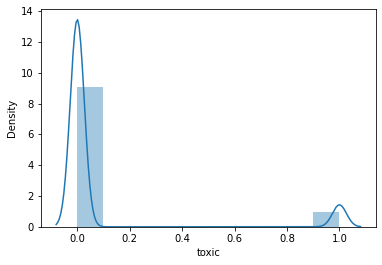

In [17]:
y = train['toxic']
sns.distplot(y, bins=10)

*Наблюдаем не равномерное распределение целевой переменной. Нулевые (не токсичные) комментарии преобладают.*

*Построим столбчатые диаграммы распределений для признаков*

In [18]:

df_num_features = train[['text', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 
                         'identity_hate_cat', 'insult_cat', 'threat_cat', 'obscene_cat', 'severe_toxic_cat', 'toxic_cat']]

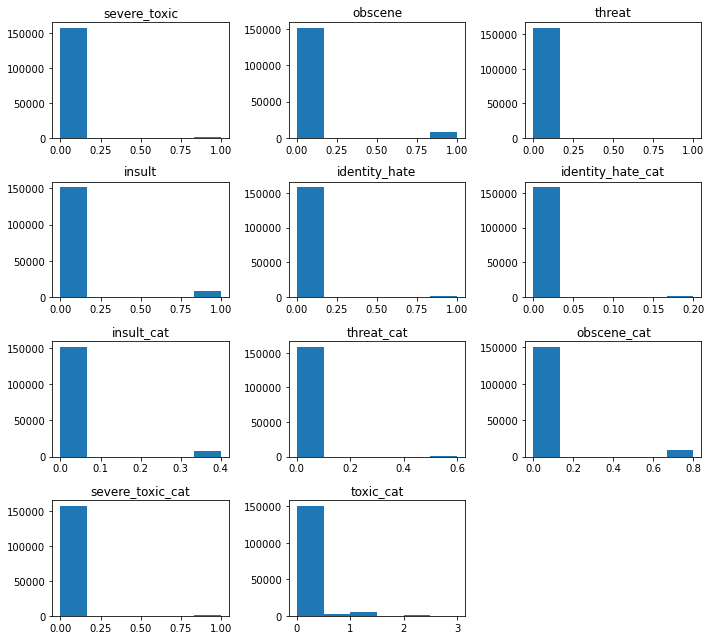

In [19]:
df_num_features.hist(figsize=(10,9), bins=6, grid=False);
plt.tight_layout()
plt.show()

*Можем наблюдать, что больше всего непристойных комментариев и с оскорблениями, т.к. токсичность этих признаков хорошо видна на графиках*

##### матрица кореляций признаков<a class='anchor' id='matrix'>

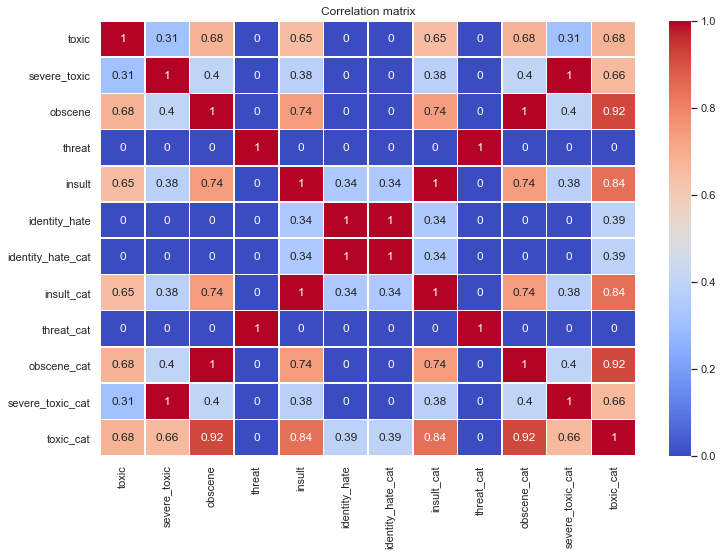

In [20]:


plt.figure(figsize = (12, 8))

sns.set(font_scale=1.0)

corr_matrix=train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

*Примерно половина всех признаков достаточно хорошо коррелируют друг с другом*

### 5. Разбиение на train и valid<a class='splitting' id='splitting'>

*Подготовим данные для разбивки на тренировочную и валидационную выборки. Тестовая выборка у нас есть.*

In [21]:
x = train.drop('toxic', axis=1)
x.head(3)

,id,text,severe_toxic,obscene,threat,insult,identity_hate,identity_hate_cat,insult_cat,threat_cat,obscene_cat,severe_toxic_cat,toxic_cat
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0


Сделаем тренировочную и тестовую выборки

In [22]:
#разделим данные на train/test
X_train, X_valid, y_train, y_valid = train_test_split(x, y,
                                                    random_state=0)

In [23]:
X_train.head(3)

,id,text,severe_toxic,obscene,threat,insult,identity_hate,identity_hate_cat,insult_cat,threat_cat,obscene_cat,severe_toxic_cat,toxic_cat
143075,fd12f8b7fe7711de,Please do not add unsourced or original conten...,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
65320,aecd3c58cea43a2e,This page needs a new update of the UMW seal. ...,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0
64545,acc1d1946d2c7259,"""\n\nOh, so sad! Why you always remind of me? ...",0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0


### 6. Построение модели<a class='model' id='model'>

Построим простое векторное представление текстов и обучим логистическую регрессию (параметр TFiDF max_features )

### модель 1. LogisticRegression

In [24]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

model = Pipeline([('comment_text_selector', FeatureSelector(column='text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=6000)), 
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

#запустим кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))



CV score is 0.9536945169001401
Wall time: 19.4 s


#### Обучение


In [25]:
%%time
#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_score = model.predict_proba(X_valid)[:, 1]

Wall time: 8.7 s


#### Оценка модели

Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог

In [26]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=1

precision, recall, thresholds = precision_recall_curve(y_valid.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l1=[]
l1.append('LogisticRegression')
l1.append(format(thresholds[ix], '.3f')), l1.append(format(fscore[ix], '.3f')),  
l1.append(format(precision[ix], '.3f')), l1.append(format(recall[ix], '.3f'))

Best Threshold=0.190682, F-Score=0.748, Precision=0.789, Recall=0.711


(None, None)

Нарисуем roc кривую

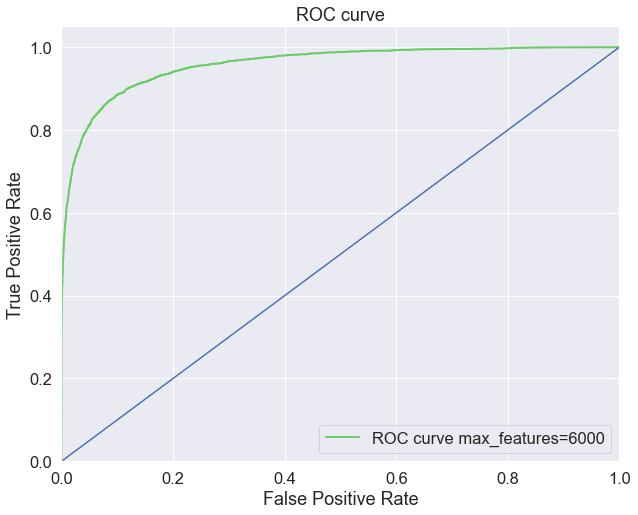

In [27]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
# fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1) # при max_features=100
# fpr1, tpr1, thresholds_ = roc_curve(y_test, y_score, pos_label=1) # при max_features=1000
# fpr2, tpr2, thresholds_ = roc_curve(y_test, y_score, pos_label=1) # при max_features=2000
# fpr3, tpr3, thresholds_ = roc_curve(y_test, y_score, pos_label=1) # при max_features=4000
fpr4, tpr4, thresholds_ = roc_curve(y_valid, y_score, pos_label=1) # при max_features=6000

# plt.plot(fpr, tpr, lw=lw,color = 'r', label='ROC curve max_features=100')
# plt.plot(fpr1, tpr1, lw=2,color = 'b', label='ROC curve max_features=1000')
# plt.plot(fpr2, tpr2, lw=1,color = 'g', label='ROC curve max_features=2000')
# plt.plot(fpr3, tpr3, lw=2,color = 'y', label='ROC curve max_features=4000')
plt.plot(fpr4, tpr4, lw=2,color = 'g', label='ROC curve max_features=6000')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

*Лучше всего себя показала модель с max_features=6000*

### модель 2. GradientBoostingClassifier

In [28]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
model2 = Pipeline([('comment_text_selector', FeatureSelector(column='text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=6000)), 
                     ('clf', GradientBoostingClassifier(random_state=42))])

#запустим кросс-валидацию
cv_scores = cross_val_score(model2, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

CV score is 0.8908426513464022
Wall time: 2min 31s


#### Обучение


In [29]:
%%time
#обучим пайплайн на всем тренировочном датасете
model2.fit(X_train, y_train)
y_score2 = model2.predict_proba(X_valid)[:, 1]

Wall time: 1min 25s


#### Оценка модели

In [30]:
precision2, recall2, thresholds2 = precision_recall_curve(y_valid.values, y_score2)
fscore2 = (1+b**2)*(precision2 * recall2) / (b**2*precision2 + recall2)
# locate the index of the largest f score
ix = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix], 
                                                                        fscore2[ix],
                                                                        precision2[ix],
                                                                        recall2[ix]))
l2=[]
l2.append('GradientBoostingClassifier')
l2.append(format(thresholds2[ix], '.3f')), l2.append(format(fscore2[ix], '.3f')),  
l2.append(format(precision2[ix], '.3f')), l2.append(format(recall2[ix], '.3f'))

Best Threshold=0.123819, F-Score=0.718, Precision=0.765, Recall=0.676


(None, None)

### модель 3. RandomForestClassifier

In [31]:
%%time
from sklearn.ensemble import RandomForestClassifier
model3 = Pipeline([('comment_text_selector', FeatureSelector(column='text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=6000)), 
                     ('clf', RandomForestClassifier(random_state = 42))])

#запустим кросс-валидацию
cv_scores = cross_val_score(model3, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

CV score is 0.949785057348384
Wall time: 6min 45s


#### Обучение


In [32]:
%%time
#обучим пайплайн на всем тренировочном датасете
model3.fit(X_train, y_train)
y_score3 = model3.predict_proba(X_valid)[:, 1]

Wall time: 4min 19s


#### Оценка модели

In [33]:
precision3, recall3, thresholds3 = precision_recall_curve(y_valid.values, y_score3)
fscore3 = (1+b**2)*(precision3 * recall3) / (b**2*precision3 + recall3)
# locate the index of the largest f score
ix = np.argmax(fscore3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds3[ix], 
                                                                        fscore3[ix],
                                                                        precision3[ix],
                                                                        recall3[ix]))
l3=[]
l3.append('RandomForestClassifier')
l3.append(format(thresholds3[ix], '.3f')), l3.append(format(fscore3[ix], '.3f')),  
l3.append(format(precision3[ix], '.3f')), l3.append(format(recall3[ix], '.3f'))

Best Threshold=0.414286, F-Score=0.755, Precision=0.799, Recall=0.716


(None, None)

### 4 модель

In [45]:
%%time
import xgboost as xgb


model4 = Pipeline([('comment_text_selector', FeatureSelector(column='text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=6000)), 
                     ('clf', xgb.XGBClassifier(random_state=42))])

#запустим кросс-валидацию
cv_scores = cross_val_score(model4, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

[14:46:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score is 0.9442691781896722
Wall time: 1min


In [46]:
%%time
#обучим пайплайн на всем тренировочном датасете
model4.fit(X_train, y_train)
y_score4 = model4.predict_proba(X_valid)[:, 1]

[14:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 32 s


In [51]:
precision4, recall4, thresholds4 = precision_recall_curve(y_valid.values, y_score4)
fscore4 = (1+b**2)*(precision4 * recall4) / (b**2*precision4 + recall4)
# locate the index of the largest f score
ix = np.argmax(fscore4)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds4[ix], 
                                                                        fscore4[ix],
                                                                        precision4[ix],
                                                                        recall4[ix]))
l4=[]
l4.append('XGBClassifier')
l4.append(format(thresholds4[ix], '.3f')), l4.append(format(fscore4[ix], '.3f')),  
l4.append(format(precision4[ix], '.3f')), l4.append(format(recall4[ix], '.3f'))

Best Threshold=0.216778, F-Score=0.758, Precision=0.791, Recall=0.728


(None, None)

### 7. Отбор лучшей модели<a class='best_model' id='best_model'>

In [52]:
my_list = list()
my_list.append(l1), my_list.append(l2), my_list.append(l3), my_list.append(l4)
my_list = pd.DataFrame(my_list, columns=['Model','Threshold', 'F-Score', 'Precision', 'Recall'])
my_list.sort_values('F-Score', ascending=False)

,Model,Threshold,F-Score,Precision,Recall
3,XGBClassifier,0.217,0.758,0.791,0.728
2,RandomForestClassifier,0.414,0.755,0.799,0.716
0,LogisticRegression,0.191,0.748,0.789,0.711
1,GradientBoostingClassifier,0.124,0.718,0.765,0.676


*Лучше всего себя показала модель XGBClassifier. F-Score составил 0,758. Если сравнивать RandomForestClassifier и  LogisticRegression, то  у модели RandomForestClassifier времени для построения пайплайна и обучения модели ушло достаточно много: чуть более 10 минут. При этом у LogisticRegression на все ушло около 30 секунд, а метрика F-Score не значительно хуже и составила 0,748, что на 0,007(или на 0,9%) меньше RandomForestClassifier.* 

### 8. Подбор гиперпараметров лучшей модели<a id='selection'>

In [63]:
params={'clf__eta':[0.1,0.3,0.6,0.9],
        'clf__subsample':[0.3,0.5,0.7],
        'clf__max_depth':[None]
        }

In [65]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

grid = GridSearchCV(model4,
                    param_grid=params,
                    cv=3,
                    n_jobs=-1,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 7min 12s


{'clf__eta': 0.1, 'clf__max_depth': None, 'clf__subsample': 0.5}

*Далее обучу модель с лучшими параметрами для получения лучшей метрики*

In [68]:
%%time
from sklearn.ensemble import RandomForestClassifier
model4 = Pipeline([('comment_text_selector', FeatureSelector(column='text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=6000)), 
                     ('clf', xgb.XGBClassifier(clf__eta= 0.1, clf__max_depth= None, subsample= 0.5, random_state=42))])

#запустим кросс-валидацию
cv_scores = cross_val_score(model4, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

[15:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "clf__eta" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:26:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "clf__eta" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

#### Обучение

In [69]:
%%time
#обучим пайплайн на всем тренировочном датасете
model4.fit(X_train, y_train)
y_score4 = model4.predict_proba(X_valid)[:, 1]

[15:28:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "clf__eta" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 24.1 s


#### Оценка модели

In [70]:
precision4, recall4, thresholds4 = precision_recall_curve(y_valid.values, y_score4)
fscore4 = (1+b**2)*(precision4 * recall4) / (b**2*precision4 + recall4)
# locate the index of the largest f score
ix = np.argmax(fscore4)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds4[ix], 
                                                                        fscore4[ix],
                                                                        precision4[ix],
                                                                        recall4[ix]))

Best Threshold=0.273098, F-Score=0.760, Precision=0.819, Recall=0.709


### 9. Оценка экономической эффективности модели<a id='grade'>

Отрисуем матрицу ошибок

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35440   605]
 [ 1119  2729]]


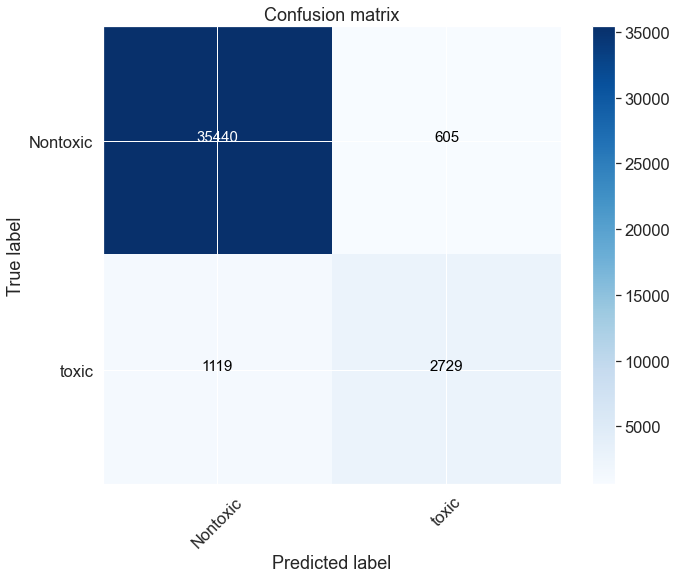

In [72]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, y_score4>thresholds4[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [73]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [74]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7091995841995842, 0.016784574837009295, 0.9832154251629907)

False Positive Rate составил всего лишь 0.016.

Это означает, что только 1.6 процента всех комментариев будут помечены как токсичные некорректно

Глобальные выводы:

1. TNR = 0.98 -> модель может автоматически фильтровать 98% токсичных комментариев
2. TPR = 0.71 -> доля ошибочно классифицированных как токсичных (хотя это нормальные комментарии), не будет превышать при этом 1.6 процентов

Пусть:
 - пропущенный комментарий стоит 150 р
 - заблокировать пользователя обойдется в 20 р

Определим где больше потерь:

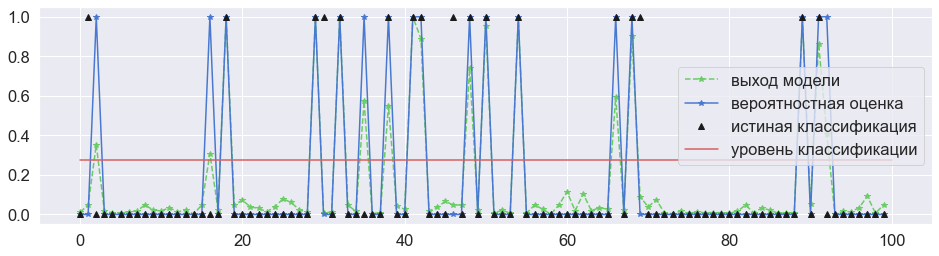

In [75]:
plt.figure(figsize=(16,4))

plt.plot(y_score4[:100] , '--*g', label = 'выход модели')
plt.plot(y_score4[:100]>thresholds4[ix], '-*b', label = 'вероятностная оценка')
plt.plot(y_valid.values[:100], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,100],[thresholds4[ix],thresholds4[ix]],'r', label = 'уровень классификации')


plt.legend()
plt.show()

На графике видим, что модель предсказывает хорошо

In [77]:
cnf_matrix = confusion_matrix(y_valid, y_score4>thresholds4[ix])


pay_toxic = cnf_matrix[1,0]*150 + cnf_matrix[0,1]*20
pay_toxic2 = (cnf_matrix[0,1]+cnf_matrix[1,1])*150
print('порог: ', thresholds4[ix], '  потери при использовании ML:',pay_toxic)
print('потери без ML:',pay_toxic2)
print('разница (без ML - с ML): ',pay_toxic2 - pay_toxic)

порог:  0.2730981   потери при использовании ML: 179950
потери без ML: 500100
разница (без ML - с ML):  320150


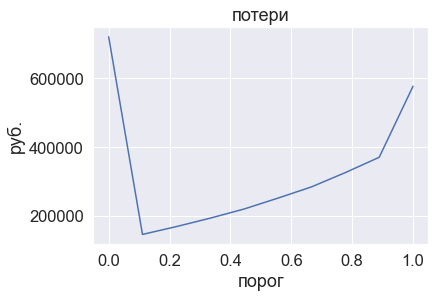

In [86]:
pay_toxic_th =[]
trh_level = np.linspace(0,1,10).tolist()
for trh in trh_level:
    cnf_matrix = confusion_matrix(y_valid, y_score4>trh)
    pay_toxic_th.append( cnf_matrix[1,0]*150 + cnf_matrix[0,1]*20)
    
plt.plot(trh_level,pay_toxic_th)
plt.ylabel('руб.')
plt.xlabel('порог')
plt.title('потери')
plt.show()

Меньше всего потерь при пороге примерно 0,16. Посчитаем бизнес метрики с этим порогом:

Confusion matrix, without normalization
[[34829  1216]
 [  880  2968]]


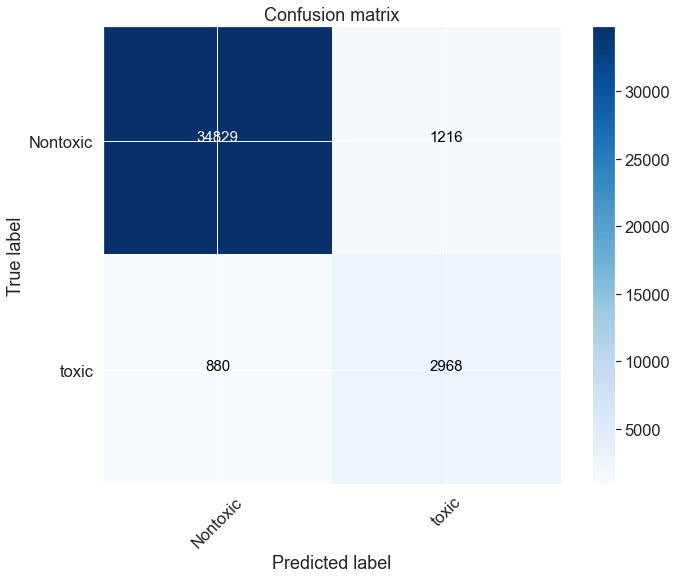

In [89]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, y_score4>0.16)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

с порогом 0,16 Фальшиво позитивных стало больше, а Фальшиво-негативных чуть меньшн. Посчитаем на сколько хуже или лучше стали бизнес метрики:

In [95]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [91]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7713097713097713, 0.03373560826744347, 0.9662643917325565)

False Positive Rate составил 0.03, не значительно больше. Всего 3 процента всех комментариев будут помечены как токсичные некорректно

In [96]:
cnf_matrix = confusion_matrix(y_valid, y_score4>0.16)


pay_toxic = cnf_matrix[1,0]*150 + cnf_matrix[0,1]*20
pay_toxic2 = (cnf_matrix[0,1]+cnf_matrix[1,1])*150
print('порог: ', 0.16, '  потери при использовании ML:',pay_toxic)
print('потери без ML:',pay_toxic2)
print('разница (без ML - с ML): ',pay_toxic2 - pay_toxic)

порог:  0.16   потери при использовании ML: 156320
потери без ML: 627600
разница (без ML - с ML):  471280


Таким образом выбрав лучшую модель, обучив ее и подобрав лучший порог, получили лучшие бизнес метрики. Экономия, при использовании модели в итоге составит 471 280 р.

## 10. Прогнозирование на тестовом датасете<a id='test'>

In [97]:
test

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...
...,...,...
7532,504235362,"Go away, you annoying vandal."
7533,504235566,This user is a vandal.
7534,504308177,""" \n\nSorry to sound like a pain, but one by f..."
7535,504570375,Well it's pretty fucking irrelevant now I'm un...


In [99]:
predicts = model4.predict_proba(test)[:, 1]
predicts

array([0.0058882 , 0.03464114, 0.00645959, ..., 0.03160464, 0.90814394,
       0.04773532], dtype=float32)

In [100]:
submit=pd.read_csv(PREPARED_TRAIN_DATASET_PATH, sep=',')
submit.head()

,comment_id,score
0,114890,0.023036
1,732895,0.034162
2,1139051,0.038069
3,1434512,0.028939
4,2084821,0.499551


In [101]:
predicts.shape

(7537,)

In [102]:
submit['score'] = predicts

In [103]:
submit.shape

(7537, 2)

Сохраним полученные вероятностные оценки в файл.

In [104]:
submit.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False)